In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features)
from cities.utils.cleaning_utils import check_if_tensed 

from pyro.infer import Predictive

In [2]:
def plot_predictive(model, data, intervention_variable, outcome_dataset, forward_shift, guide = None, **kwargs):

    model = condition(data=dict(**kwargs))(model)
    
    #if guide:
    #    guide_tr = pyro.poutine.trace(guide).get_trace()
    #    model_tr = pyro.poutine.trace(pyro.poutine.replay(model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
    #                            time_index = time_index, intervention = intervention), trace=guide_tr)).get_trace()
    #else:
    with pyro.poutine.trace() as tr:
        model(**kwargs)

    model_tr = tr.trace
    y = model_tr.nodes['y']['value']

    predictive_copy = data.copy()

    predictive_copy['post_test'] = y.reshape(-1, 1).detach().numpy()  

    sns.pairplot(predictive_copy[[intervention_variable, f"{outcome_dataset}_shifted_by_{forward_shift}", 'post_test']])
    

In [3]:
dg = DataGrabber()


outcome_dataset = 'unemployment_rate'
intervention_dataset = 'spending_commerce'
intervention_variable = 'total_obligated_amount'
forward_shift = 2

tensed_covariates_datasets = [var for var in list_tensed_features() if var not in [outcome_dataset, intervention_dataset]]
fixed_covariates_datasets = [var for var in list_available_features() if var not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]]

dg.get_features_std_long(list_available_features()) 
dg.get_features_std_wide(list_available_features()) 

year_min = max(dg.std_long[intervention_dataset]['Year'].min(), dg.std_long[outcome_dataset]['Year'].min())
year_max = min(dg.std_long[intervention_dataset]['Year'].max(), dg.std_long[outcome_dataset]['Year'].max())

outcome_df = dg.std_long[outcome_dataset].sort_values(by=['GeoFIPS', 'Year'])

outcome_df[f'{outcome_dataset}_shifted_by_{forward_shift}'] = None

geo_subsets = []
for geo_fips in outcome_df['GeoFIPS'].unique():
    geo_subset = outcome_df[outcome_df['GeoFIPS'] == geo_fips].copy()
    # Shift the 'Value' column `forward_shift` in a new column
    geo_subset[f'{outcome_dataset}_shifted_by_{forward_shift}'] = geo_subset['Value'].shift(-forward_shift)
    geo_subsets.append(geo_subset)
    
outcome_df = pd.concat(geo_subsets).reset_index(drop=True)

outcome = outcome_df[(outcome_df['Year'] >= year_min) & (outcome_df['Year'] <= year_max + forward_shift)]
intervention = dg.std_long[intervention_dataset][(dg.std_long[intervention_dataset]['Year'] >= year_min) & (dg.std_long[intervention_dataset]['Year'] <= year_max)]    
f_covariates = {dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if 'GeoName' in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=['GeoName'])
        f_covariates_joint = f_covariates_joint.merge(f_covariates[dataset], on=['GeoFIPS'])

T_outcome = year_max - year_min + 1

i_o_data = pd.merge(outcome, intervention, on=['GeoFIPS', 'Year'])

if 'GeoName_x' in i_o_data.columns:
    i_o_data.rename(columns={'GeoName_x': "GeoName"}, inplace=True)    
    columns_to_drop = i_o_data.filter(regex=r'^GeoName_[a-zA-Z]$')
    i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

i_o_data.rename(columns={'Value': outcome_dataset}, inplace=True)

i_o_data['state'] = [code // 1000 for code in i_o_data['GeoFIPS']]

N_states = len(i_o_data['state'].unique())

i_o_data.dropna(inplace=True)

i_o_data['unit_index']= pd.factorize(i_o_data['GeoFIPS'].values)[0]
i_o_data['state_index']= pd.factorize(i_o_data['state'].values)[0]
i_o_data['time_index']= pd.factorize(i_o_data['Year'].values)[0]


assert i_o_data['GeoFIPS'].isin(f_covariates_joint['GeoFIPS']).all()

print(i_o_data.shape)
f_covariates_joint.drop(columns=['GeoName'], inplace=True)
data = i_o_data.merge(f_covariates_joint, on='GeoFIPS', how='left')

assert not data.isna().any().any()

(9124, 10)


In [4]:
# getting tensors for modeling
y = data[f'{outcome_dataset}_shifted_by_{forward_shift}']
y = torch.tensor(y, dtype=torch.float32) 
unit_index = torch.tensor(data['unit_index'], dtype=torch.int)
state_index = torch.tensor(data['state_index'], dtype=torch.int)
time_index = torch.tensor(data['time_index'], dtype=torch.int)
intervention = torch.tensor(data[intervention_variable], dtype=torch.float32)
time_index_idx = data.columns.get_loc('time_index')
covariates_df = data.iloc[:, time_index_idx + 1:].copy()
covariates = torch.tensor(covariates_df.values, dtype = torch.float32)

N_cov = covariates.shape[1]

In [5]:
# one way to think about this
import scipy
correlation, _ = scipy.stats.pearsonr(intervention, y)
print(correlation)

# another one
# suppose we care about minimal intervention vs. well-funded places
minimal = data[data['total_obligated_amount'] < -.9]
well = data[(data['total_obligated_amount'] >= .9)]

naive_empirical_estimate = np.mean(well['unemployment_rate_shifted_by_2']) - np.mean(minimal['unemployment_rate_shifted_by_2'])

print(naive_empirical_estimate)

-0.022496748879319295
-0.39838727829041526


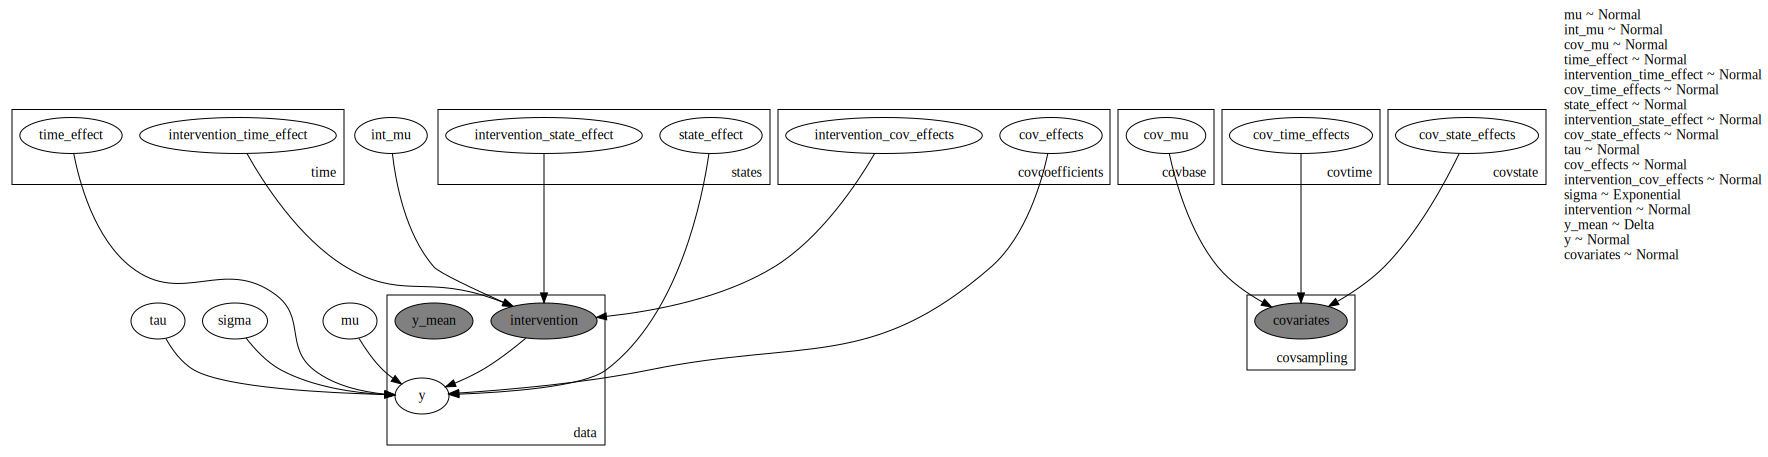

In [55]:
# like model C, but now also covariates are a function
# of time effects and state effects

def cities_model_D(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        
        # Intercepts
        mu = pyro.sample("mu", dist.Normal(0, .4))
        intervention_mu = pyro.sample("int_mu", dist.Normal(0, .4))


        with pyro.plate("covbase", N_cov):
                cov_mu = pyro.sample("cov_mu", dist.Normal(0, .4))
 

        # time effect
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .5))
                intervention_time_effect = pyro.sample("intervention_time_effect", dist.Normal(0, .5))
        
        with pyro.plate("covtime",  T_outcome * N_cov):
                cov_time_effects = pyro.sample("cov_time_effects",
                                                       dist.Normal(0, 0.5)).reshape(T_outcome, N_cov)


        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .5))
                intervention_state_effect = pyro.sample("intervention_state_effect", dist.Normal(0, .5))

        with pyro.plate("covstate", N_states * N_cov):
                cov_state_effects = pyro.sample("cov_state_effects",
                                                        dist.Normal(0, 0.5)).reshape(N_states, N_cov)

        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .5))

        # covariate coefficients
        with pyro.plate("covcoefficients", N_cov):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .5))
                intervention_cov_effects = pyro.sample("intervention_cov_effects", dist.Normal(0, .5))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):

                intervention_mean = (intervention_mu + intervention_time_effect[time_index]
                                      + intervention_state_effect[state_index] +
                                        torch.matmul(covariates, intervention_cov_effects)
                )
                intervention = pyro.sample("intervention", dist.Normal(intervention_mean, 0.5), obs = intervention)

                covariates_means = cov_mu + cov_time_effects[time_index] + cov_state_effects[state_index]

                y_mean = pyro.deterministic("y_mean", mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        with pyro.plate("covsampling", len(time_index) * N_cov):
                covariates = pyro.sample("covariates",
                        dist.Normal(covariates_means.flatten(), 0.5), 
                        obs = covariates.flatten()).reshape(len(time_index), 
                                                            N_cov)

        return  {"y_mean": y_mean, "tau": tau}

cities_model_D(T_outcome, N_states, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_D, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


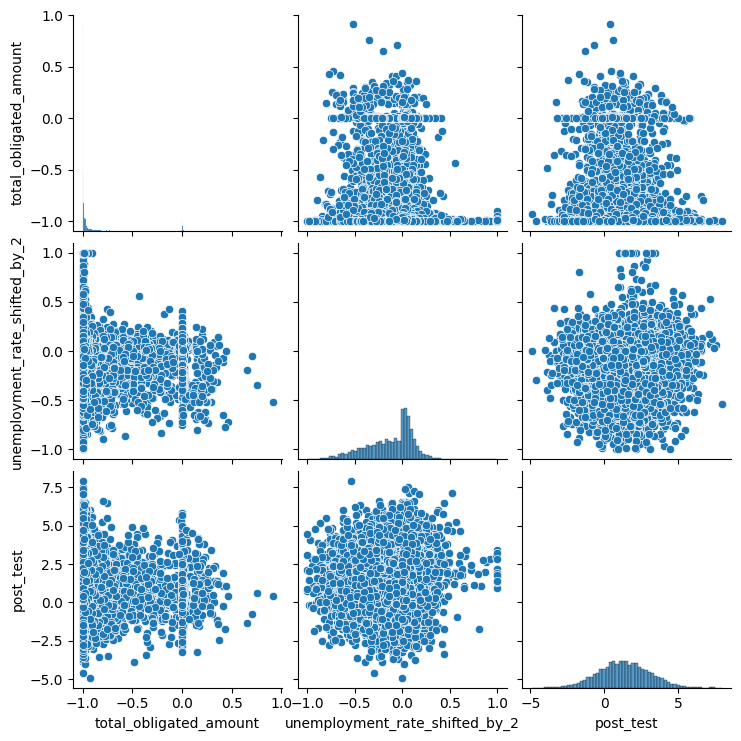

In [56]:
plot_predictive(cities_model_D, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, T_outcome=T_outcome,
  N_states=N_states, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

In [61]:
pyro.clear_param_store()
guide_D =  AutoNormal(cities_model_D)


svi = SVI(
    model=cities_model_D,
    guide=guide_D,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 24.6335
[iteration 0101] loss: 13.6423
[iteration 0201] loss: 12.5231
[iteration 0301] loss: 11.8588
[iteration 0401] loss: 11.9870
[iteration 0501] loss: 11.4357
[iteration 0601] loss: 10.9128
[iteration 0701] loss: 11.0821
[iteration 0801] loss: 10.7845
[iteration 0901] loss: 11.7082
[iteration 1001] loss: 10.5398
[iteration 1101] loss: 10.4667
[iteration 1201] loss: 10.0750
[iteration 1301] loss: 10.5563
[iteration 1401] loss: 9.7335
[iteration 1501] loss: 9.9079
[iteration 1601] loss: 10.5260
[iteration 1701] loss: 9.6783
[iteration 1801] loss: 9.5884
[iteration 1901] loss: 9.8805
[iteration 2001] loss: 9.4277
[iteration 2101] loss: 9.3567
[iteration 2201] loss: 9.3999
[iteration 2301] loss: 10.7884
[iteration 2401] loss: 9.1223
[iteration 2501] loss: 9.0154
[iteration 2601] loss: 9.9721
[iteration 2701] loss: 9.1018
[iteration 2801] loss: 8.7340
[iteration 2901] loss: 8.8414
[iteration 3001] loss: 8.9456
[iteration 3101] loss: 8.9663
[iteration 3201] loss: 8

In [108]:
# parallel=True throws Runtime error, why?
predictive_D = pyro.infer.Predictive(cities_model_D, guide=guide_D, num_samples=100, parallel=False)
samples_D = predictive_D(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

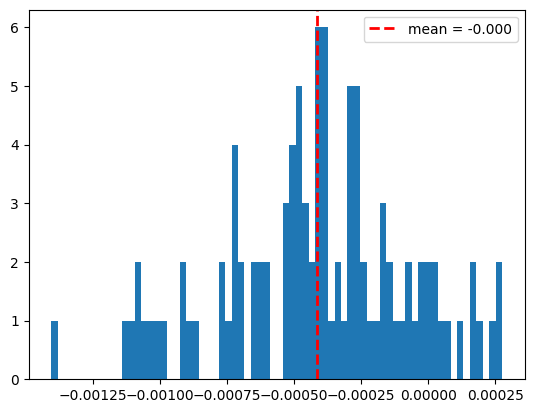

In [109]:
# estimate with covariates and latent confounders impacting covariates, intervention, and outcome
tau_samples = samples_D['tau'].detach().numpy()
plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

In [134]:
# awfully hacky, but neither changing num_samples nor using plate works

predictive_D_single = pyro.infer.Predictive(cities_model_D, guide=guide_D, 
                                            num_samples=1, return_sites=("tau", "y_mean", "y"))
with MultiWorldCounterfactual() as mwc:
    with do(actions=dict(intervention=(-0.9, .9))):
            samples_D_counterfactual = []
            for _ in range(100):
                 samples_D_counterfactual.append(predictive_D_single(T_outcome = T_outcome, N_states = N_states, 
                                                        state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates))

with mwc:        
    low = []
    high = []
    for i in range (10):
        low.extend(gather(samples_D_counterfactual[0]['y_mean'], IndexSet(intervention={1})).squeeze().tolist())
        high.extend(gather(samples_D_counterfactual[0]['y_mean'], IndexSet(intervention={2})).squeeze().tolist())

diff = np.mean(high) - np.mean(low)


print(diff)


-0.0012456327676773071


In [93]:
print(samples_D['y'].keys())

AttributeError: 'Tensor' object has no attribute 'keys'

In [22]:
# this is a strange and hacky way
# used as pyro.poutine throws mutliple sites error
# despite there being no multiple sites with the same name
# in the mode

predictive_D2 = pyro.infer.Predictive(cities_model_D, guide=guide_D, num_samples=1, return_sites=("tau", "y_mean", "y"))

with MultiWorldCounterfactual() as mwc:
    with do(actions=dict(intervention=(-0.9, .9))):
            out =  predictive_D2(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

with mwc:
    low = gather(out['y'], IndexSet(intervention={1}))
    high = gather(out['y'], IndexSet(intervention={2}))

print(high.mean() - low.mean())
        

tensor(-0.0203)


In [23]:
# now suppose I care only about a particular location

fips = 1003

unit_data = data[data['GeoFIPS'] == fips]
unit_row = unit_data.iloc[-4]

y_unit = unit_row[f'{outcome_dataset}_shifted_by_{forward_shift}'].tolist()
y = torch.tensor([y_unit], dtype=torch.float32) 
unit_index_unit = torch.tensor(unit_row['unit_index'], dtype=torch.int).reshape(1)
state_index_unit = torch.tensor(unit_row['state_index'], dtype=torch.int).reshape(1)
time_index_unit = torch.tensor(unit_row['time_index'], dtype=torch.int).reshape(1)
intervention_unit = torch.tensor(unit_row[intervention_variable], dtype=torch.float32).reshape(1)
covariates_df_unit = unit_row.iloc[time_index_idx + 1:].copy().tolist()
covariates_unit = torch.tensor(covariates_df_unit, dtype = torch.float32)



In [24]:
# print(
#     cities_model_D(N_states, T_outcome, state_index = state_index_unit,
#                                 time_index = time_index_unit,
#                                   intervention = intervention_unit,
#                                     covariates = covariates_unit, 
#                                     y = y_unit)
# )


with MultiWorldCounterfactual() as mwc:
  with do(actions=dict(intervention=(-0.9, .9))):
      #with pyro.plate("sampling_ind", 100, dim=-2):
        out_ind = predictive_D2(T_outcome = T_outcome, N_states = N_states, state_index = state_index_unit,
                                time_index = time_index_unit, intervention = intervention_unit,
                                  covariates = covariates_unit)

print(
   out_ind['y']
)

# with MultiWorldCounterfactual() as mwc:
#     with do(actions=dict(intervention=(-0.9, .9))):
#             out =  predictive_D2(T_outcome = T_outcome, N_states = N_states, state_index = state_index_unit,
#                                 time_index = time_index_unit, intervention = intervention, covariates = covariates)

# with mwc:
#     low = gather(out['y'], IndexSet(intervention={1}))
#     high = gather(out['y'], IndexSet(intervention={2}))

# print(high.mean() - low.mean())


tensor([[[[[[-1.6812]]]],



         [[[[ 0.8533]]]],



         [[[[ 0.0038]]]]]])


### Latent confounders have impact on intervention

/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


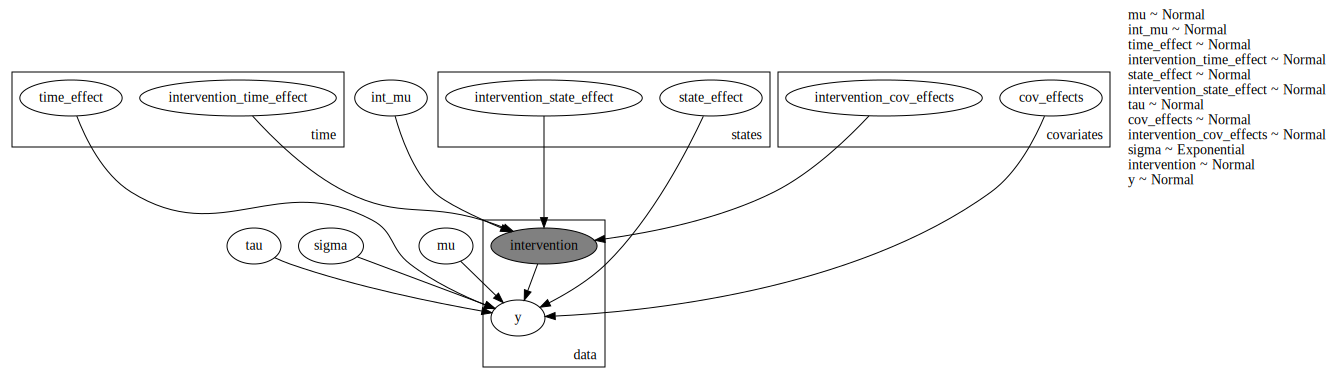

In [5]:
# like model B, but now treatment is a function
# of time effects, state effects, and covariates


def cities_model_C(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, .9))
        intervention_mu = pyro.sample("int_mu", dist.Normal(0, .9))

        # time effects
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .9))
                intervention_time_effect = pyro.sample("intervention_time_effect", dist.Normal(0, .9))
               
        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .9))
                intervention_state_effect = pyro.sample("intervention_state_effect", dist.Normal(0, .9))

        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .9))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .8))
                intervention_cov_effects = pyro.sample("intervention_cov_effects", dist.Normal(0, .8))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                # print(unit_index)
                
                intervention_mean = (intervention_mu + intervention_time_effect[time_index]
                                      + intervention_state_effect[state_index] +
                                        torch.matmul(covariates, intervention_cov_effects)
                )
                intervention = pyro.sample("intervention", dist.Normal(intervention_mean, 0.9), obs = intervention)


                y_mean = (mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

cities_model_C(T_outcome, N_states, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_C, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


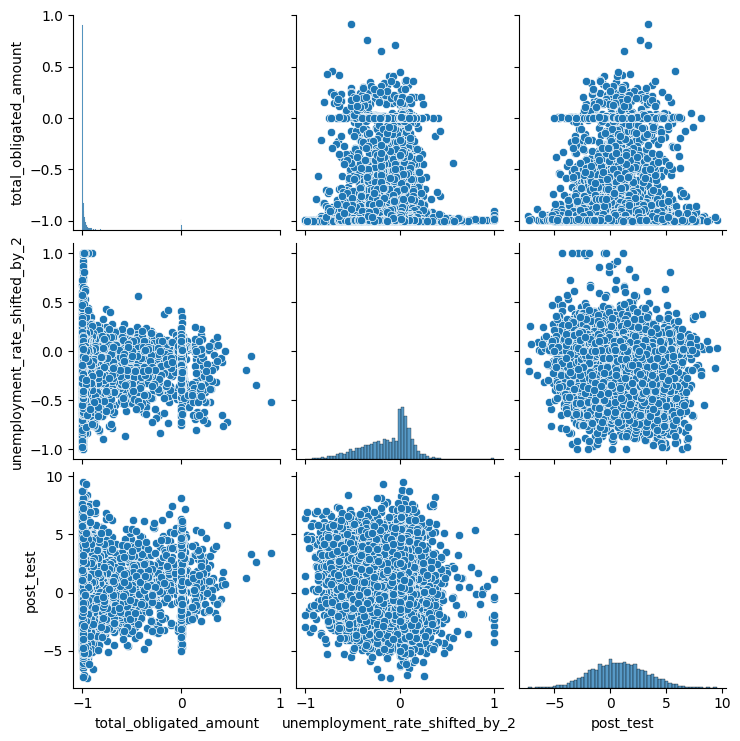

In [6]:
plot_predictive(cities_model_C, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, T_outcome=T_outcome,
  N_states=N_states, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

In [7]:
pyro.clear_param_store()
guide_C =  AutoNormal(cities_model_C)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_C,
    guide=guide_C,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 2.1006
[iteration 0101] loss: 1.2035
[iteration 0201] loss: 1.1685
[iteration 0301] loss: 0.7481
[iteration 0401] loss: 0.7114
[iteration 0501] loss: 0.7159
[iteration 0601] loss: 0.6827
[iteration 0701] loss: 0.7104
[iteration 0801] loss: 0.5678
[iteration 0901] loss: 0.5843


In [8]:
predictive_C = pyro.infer.Predictive(cities_model_C, guide=guide_C, num_samples=1000, parallel=False)
samples_C = predictive_C(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

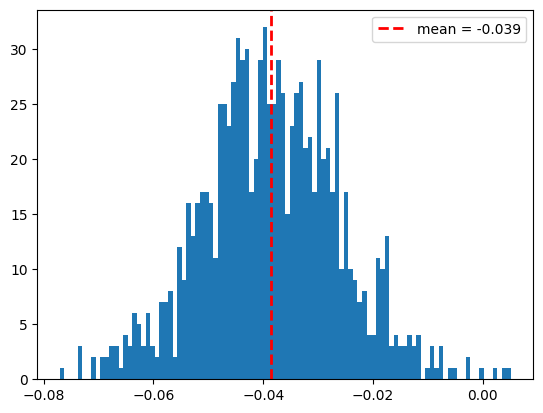

In [9]:
# estimate with covariates and latent confounders impacting intervention

tau_samples = samples_C['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

### Including covariates


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


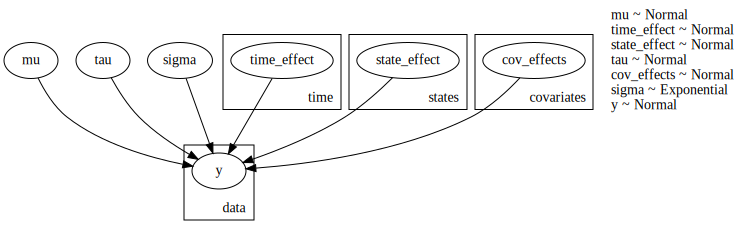

In [5]:
# like vanilla, but with covariates
# and we narrow down the priors as the posterior checked
# revealed too wide posterior


def cities_model_B(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, .9))

        # time effects
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .9))

        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .9))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .9))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .8))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                # print(unit_index)
                

                y_mean = (mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

cities_model_B(T_outcome, N_states, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_B, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


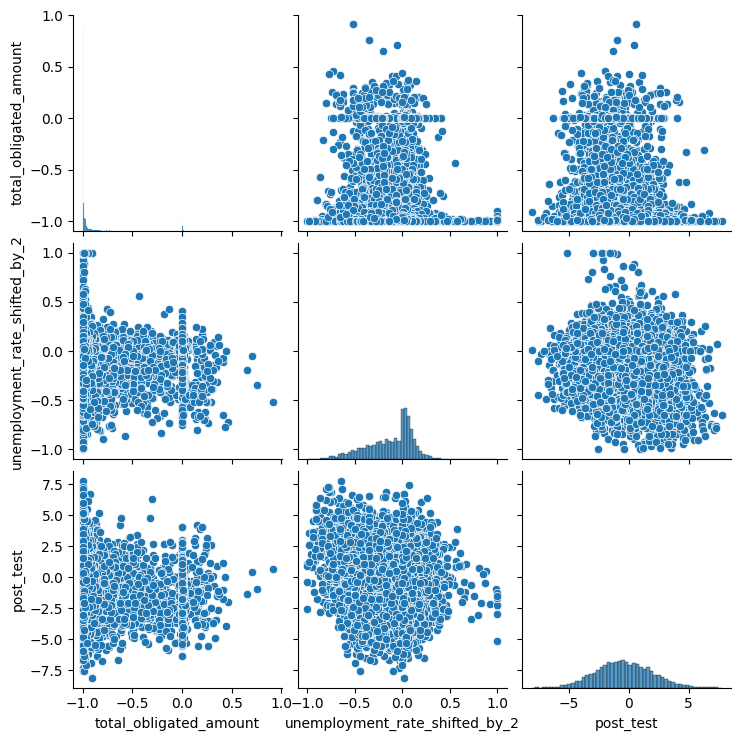

In [6]:
plot_predictive(cities_model_B, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, T_outcome=T_outcome,
  N_states=N_states, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)


In [7]:
pyro.clear_param_store()
guide_B =  AutoNormal(cities_model_B)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_B,
    guide=guide_B,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 0.9400
[iteration 0101] loss: 0.1906
[iteration 0201] loss: -0.0072
[iteration 0301] loss: 0.1215
[iteration 0401] loss: -0.2284
[iteration 0501] loss: -0.0629
[iteration 0601] loss: -0.2875
[iteration 0701] loss: -0.2933
[iteration 0801] loss: -0.3007
[iteration 0901] loss: -0.2932


In [8]:
predictive_B = pyro.infer.Predictive(cities_model_B, guide=guide_B, num_samples=1000, parallel=False)
samples_B = predictive_B(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

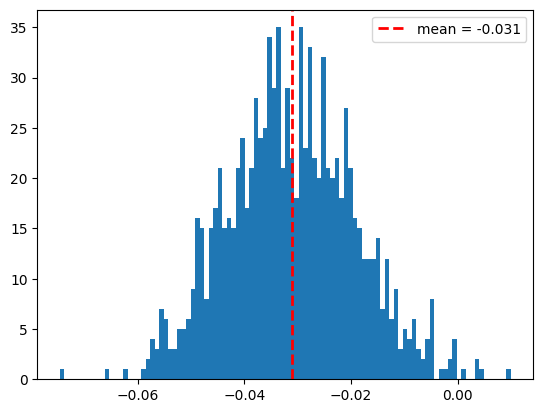

In [9]:
# this is a slightly less naive estimate

tau_samples = samples_B['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

## Vanilla model

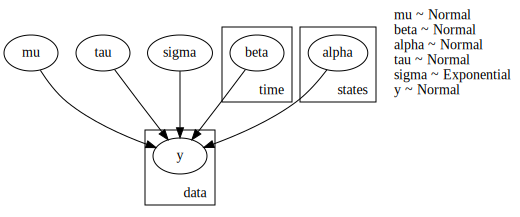

In [42]:
def cities_model_A(T_outcome, N_states, state_index, time_index, intervention,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, 1))

        # time effects
        with pyro.plate("time", T_outcome):
                beta = pyro.sample("beta", dist.Normal(0, 1))

        # state latent confounders
        with pyro.plate("states", N_states):
                alpha = pyro.sample("alpha", dist.Normal(0, 1))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, 1))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                y_mean = mu  + beta[time_index]  + alpha[state_index] + tau * intervention
                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

pyro.render_model(cities_model_A, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

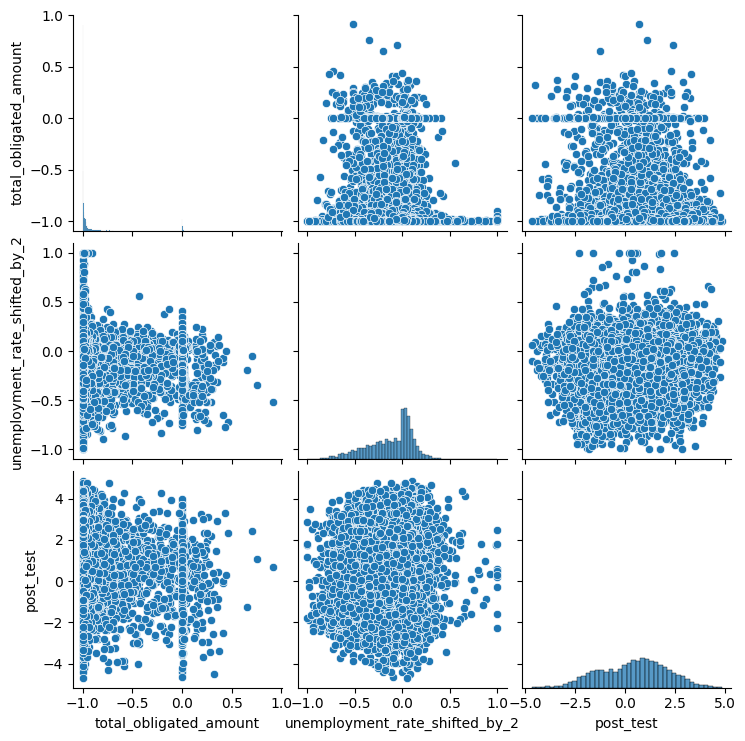

In [44]:
plot_predictive(cities_model_A, T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

In [45]:
pyro.clear_param_store()
guide =  AutoNormal(cities_model_A)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_A,
    guide=guide,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 0.8767
[iteration 0101] loss: 0.3041
[iteration 0201] loss: -0.0483
[iteration 0301] loss: -0.1652
[iteration 0401] loss: -0.1752
[iteration 0501] loss: -0.1711
[iteration 0601] loss: -0.1812
[iteration 0701] loss: -0.1814
[iteration 0801] loss: -0.1814
[iteration 0901] loss: -0.1801


In [46]:
predictive = pyro.infer.Predictive(cities_model_A, guide=guide, num_samples=1000, parallel=False)
samples = predictive(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

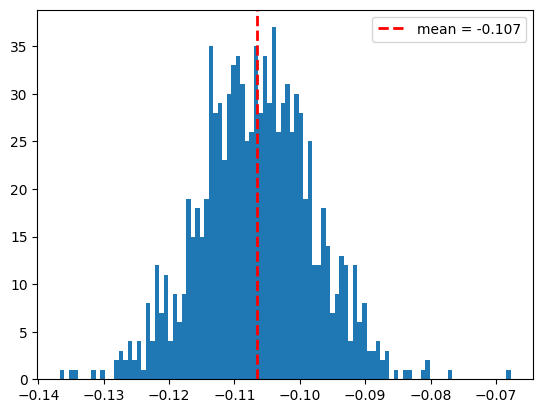

In [47]:
# this is a naive estimate

tau_samples = samples['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()